In [ ]:
import sys
!{sys.executable} -m pip install deap

gen	nevals	avg     	min     	max     
0  	50    	0.805538	0.692308	0.861538
1  	36    	0.826462	0.738462	0.876923
2  	42    	0.831692	0.753846	0.876923
3  	39    	0.831692	0.738462	0.876923
4  	38    	0.839692	0.738462	0.876923
5  	36    	0.84    	0.738462	0.876923
6  	36    	0.841846	0.738462	0.876923
7  	29    	0.854769	0.707692	0.892308
8  	37    	0.858462	0.784615	0.892308
9  	38    	0.872615	0.830769	0.892308
10 	38    	0.868615	0.784615	0.892308
11 	41    	0.874769	0.784615	0.892308
12 	33    	0.879077	0.784615	0.892308
13 	36    	0.884615	0.815385	0.892308
14 	40    	0.886462	0.784615	0.892308
15 	31    	0.888923	0.753846	0.892308
16 	41    	0.888923	0.784615	0.892308
17 	39    	0.890154	0.784615	0.892308
18 	38    	0.888615	0.784615	0.892308
19 	38    	0.886154	0.753846	0.892308
20 	41    	0.884615	0.753846	0.892308
Best ranked features:  [0, 12, 8]
Accuracy:  0.8923076923076924
              precision    recall  f1-score   support

           0       0.86      0.97      0.92  

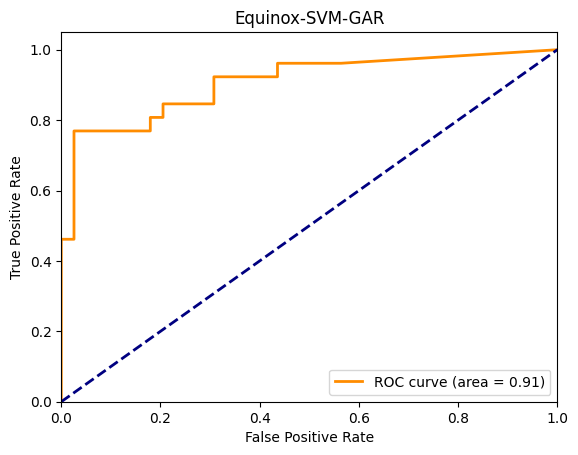

In [1]:
import sys
!{sys.executable} -m pip install deap
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer  # For handling NaNs
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Load the data
data = pd.read_csv('equinox.csv')

# Convert 'bugs' column to binary (assuming 0 means no bug, and >0 means there's a bug)
data['bugs_binary'] = data['bugs'].apply(lambda x: 1 if x > 0 else 0)

# Pre-process the data
columns_to_drop = ['classname', 'bugs', 'nonTrivialBugs', 'majorBugs', 'criticalBugs', 'highPriorityBugs', 'bugs_binary']
X = data.drop(columns=columns_to_drop)
y = data['bugs_binary']

# Handle NaN values
X = X.dropna(axis=1, how='all')
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X))
X_imputed.columns = X.columns
X_imputed.index = X.index
X = X_imputed

# Ensure all values are non-negative
negative_features = X.columns[(X < 0).any()]
X = X.drop(columns=negative_features)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluation function for ranking
def evalMetricRanking(individual):
    X_train_ordered = X_train.iloc[:, individual]
    X_test_ordered = X_test.iloc[:, individual]
    
    # For demonstration, just using first three ordered features for evaluation
    X_train_selected = X_train_ordered.iloc[:, :3]
    X_test_selected = X_test_ordered.iloc[:, :3]
    
    clf = SVC(probability=True)
    clf.fit(X_train_selected, y_train)
    y_pred = clf.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy,

# Setting up the Genetic Algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
N_FEATURES = X_train.shape[1]
toolbox.register("indices", random.sample, range(N_FEATURES), N_FEATURES)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalMetricRanking)

pop = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=20, stats=stats, halloffame=hof, verbose=True)

best_ranking = hof[0]
selected_features = best_ranking[:3]
print("Best ranked features: ", selected_features)

X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

clf = SVC(probability=True)
clf.fit(X_train_selected, y_train)

y_pred = clf.predict(X_test_selected)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_pred_proba = clf.predict_proba(X_test_selected)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

df = pd.DataFrame({
    'AUC': [roc_auc],
    'FPR': [fpr],
    'TPR': [tpr]
})
df.to_csv('./AUC_Extracts/Equinox/Equinox_SVM_GAR.csv', index=False)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Equinox-SVM-GAR')
plt.legend(loc="lower right")
plt.show()
